In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from bgspy.learn import LearnedFunction, LearnedB


In [3]:
f = LearnedFunction.load("../data/slim_sims/bmap_hg38_reps/bmap_hg38_reps_data.pkl")
f.split()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, None)
  - sh ∈ [-5, -1] (log10, None)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, None)
  - rf ∈ [-10, -0.824] (log10, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? True, test size: 20.0% (n=40,000)
Total size: 200,000

In [4]:
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=Ridge(),
                                  func=np.log,
                                  inverse_func=np.exp)

In [31]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()), ('regr', Ridge())])
pipe.fit(f.X_train, f.y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('regr', Ridge())])

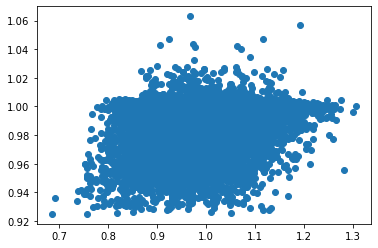

In [32]:
plt.scatter(f.y_test, pipe.predict(f.X_test))

(0.9, 1.03)

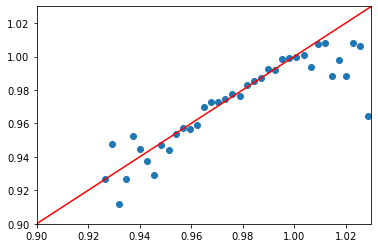

In [33]:
def binned_plot(model, X_test, y_test, nbins):
    ypred = model.predict(X_test)
    bins = np.linspace(ypred.min(), ypred.max(), nbins)
    y_bins = stats.binned_statistic(ypred, y_test, bins=nbins)
    edges = y_bins.bin_edges
    x = 0.5*(edges[:-1]+edges[1:])
    y =  y_bins.statistic
    plt.scatter(x, y)
    o = min(edges)
    plt.axline((o, o), slope=1, c='r')
    xx, yy = x[y <= 1], y[y <= 1]
    return np.nanmean((xx-yy)**2)
    
binned_plot(pipe, f.X_test, f.y_test, 50)
plt.ylim(0.90, 1.03)
plt.xlim(0.90, 1.03)

In [34]:
param_grid = {'poly__degree': np.arange(1, 10), 'regr__alpha': np.logspace(-3, 2, 10)}

In [35]:
search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', n_jobs=50)

In [ ]:
search.fit(f.X_train, f.y_train)

In [ ]:
print(search.best_params_)

In [ ]:
binned_plot(pipe, f.X_test, f.y_test, 100)
